## Fundamentals of Social Data Science
# Week 4 Day 1 Lab. Classification 

In this lab, you will be encouraged to explore your subreddits of choice using multinomial naive bayes and k-means classifications. Determine which one is more suitable using accuracy scores. Use both the TfIDFVectorizer and the CountVectorizer. 

Consider the use of stop words and lemmatisation. 

1. Plot the documents using t-SNE and then color the documents according the most accurate solution. 
2. For Naive Bayes report the 5 most informative terms per solution.  
* Would you be able to report the 5 most informative terms with k-means? This would be a bit far out for this lecture but if you are adventurous you can explore approaches like k-nearest neighbors using the centroids (as in report the 5 nearest neighbors to the centroid for each of the k solutions). 

There is only limited example code for this exercise. It is up to you to stitch together what you have learned as well as potentially draw upon external sources. On Wednesday we will provide an example solution.

Some guidance: 
1. Transform your headlines into a list similar to the walkthrough: [("headline (and maybe selftext)", "subreddit_label"), ("next headline", "next subreddit_label")]
 * Create one long list for all three subreddits to send to the Vectorizer. This is different to what I showed in Week 3 Day 3 where we had a separate vectorizer for each subreddit. To help you out I've started some code that creates a DataFrame for all the subs. 
2. Consider your tokenization. Will you use stop words or not? 
3. Consider plotting the classification on t-SNE to get some intuitions for how the solution maps out visually. 
4. Remember, are you classifying the documents using the terms? Or classifying the terms using the documents? Be careful with how you set this up. Notice that in the examples in the walkthrough we were classifying the documents using the terms. 
5. Consider the structure of this repository. Will you want to place some code for a plotting function in the `analysis.py`? What about creating a function under `text_processor.py` to transform the reddit data into the data structure needed. You can do everything in this Jupyter lab notebook but you should use this opportunity to think about how you might make use of this structure in order to help keep your code tidy. 


In [1]:
import os
import pickle
from models.reddit_scraper import RedditScraper
from config.settings import USER_AGENT
from utils.analysis import *

scraper = RedditScraper(USER_AGENT)
subs_of_interest = ['TooAfraidToAsk', 'AskMen', 'AskWomen']

posts_list = []

for sub in subs_of_interest:    
    posts = scraper.get_subreddit_posts(sub, limit=100, cache=True)
    df = create_posts_dataframe(posts)
    df['subreddit'] = sub
    posts_list.append(df)

posts_df = pd.concat(posts_list)
posts_df = posts_df.reset_index(drop=True)


In [2]:
# Naive Bayes Classifier

Summarise NBC results: 



In [3]:
posts_df.head()

,title,selftext,url,domain,time,author,subreddit
0,Why do older women seem so affectionate and ca...,"Many older women I meet through my mom, aunts,...",https://www.reddit.com/r/TooAfraidToAsk/commen...,None,2024-11-06 18:30:32,ATATwalker92737,TooAfraidToAsk
1,Why are beginner/advice subreddits so toxic?,Why are beginner/advice subreddits so toxic? T...,https://www.reddit.com/r/TooAfraidToAsk/commen...,None,2024-11-06 18:26:02,Solid_Arachnid_9231,TooAfraidToAsk
2,Can someone give any advices?,My mental health has been going down rapidly a...,https://www.reddit.com/r/TooAfraidToAsk/commen...,None,2024-11-06 18:21:15,Quick-Leadership-612,TooAfraidToAsk
3,Why does the left whine about the constitution...,,https://www.reddit.com/r/TooAfraidToAsk/commen...,None,2024-11-06 18:13:25,Connorray1234,TooAfraidToAsk
4,Is it feasibly possible for a truly left-leani...,If a truly progressive candidate were actually...,https://www.reddit.com/r/TooAfraidToAsk/commen...,None,2024-11-06 18:11:35,NovaPractice,TooAfraidToAsk


In [4]:
posts_df["full_text"] = posts_df["title"] + " " + posts_df["selftext"]

label_pairs = [(text, subreddit) for text, subreddit in zip(posts_df['title'], posts_df['subreddit'])]

corpus_text = [p[0] for p in label_pairs]
corpus_labels = [p[1] for p in label_pairs]

vectorizer = TfidfVectorizer(min_df=2, stop_words=None)
tfidf_matrix = vectorizer.fit_transform(corpus_text)

In [5]:
from utils.analysis import plot_word_similarities_tsne

word_feature_names = vectorizer.get_feature_names_out()

# plot_word_similarities_tsne(
#     tfidf_matrix=tfidf_matrix,
#     feature_names=word_feature_names,
# )

In [6]:
# K-means Classifier
from sklearn.cluster import KMeans

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(tfidf_matrix)

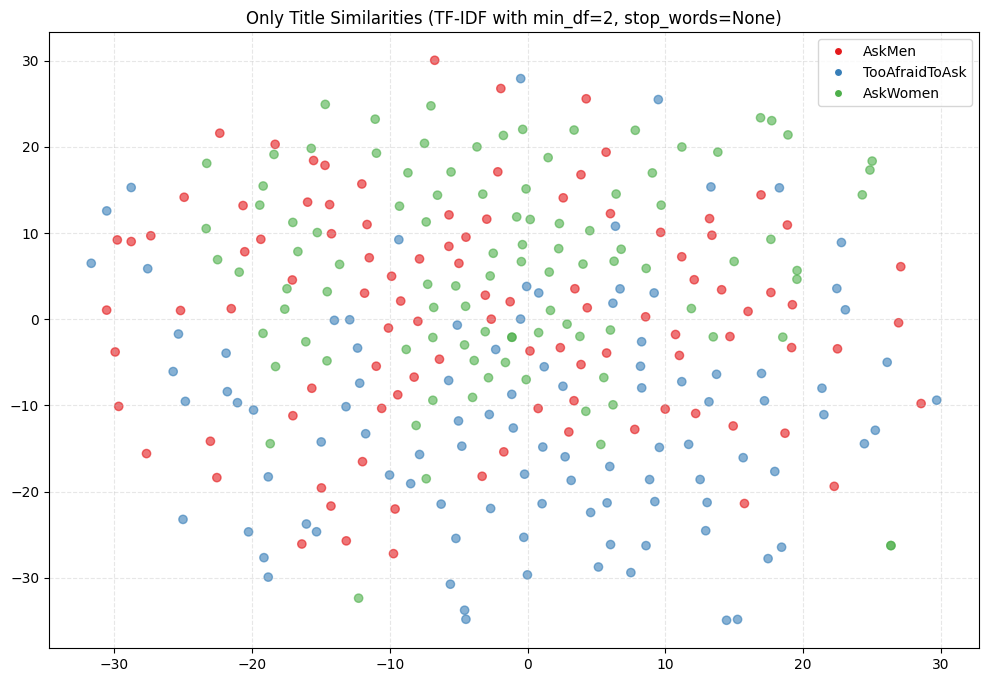

In [9]:
from utils.analysis import plot_similarities

# TODO: plot the clusters in 2D, and do some analysis on the top terms in each cluster
# Plot document similarities
fig_doc, ax_doc = plot_similarities(
    tfidf_matrix, 
    corpus_labels,
    label_color=True,
    use_text_annotations=False,
    title="Only Title Similarities (TF-IDF with min_df=2, stop_words=None)",
    is_documents=True # This is the default, but we'll specify it here for clarity
)

Summarise k-Means results